## Notes

I wraped up functions to be copy pasted during the workshop.

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import imageio.v3 as iio
import skimage.color
import skimage.filters
%matplotlib widget

In [2]:
# my "extra" function
def plot_hist(img, bins, x_min, x_max):
    histogram, bin_edges = np.histogram(img, bins, range=(x_min, x_max))

    fig, ax = plt.subplots()
    plt.plot(bin_edges[0:-1], histogram)
    plt.title("Grayscale Histogram")
    plt.xlabel("grayscale value")
    plt.ylabel("pixels")
    plt.xlim(x_min, x_max)

### Simple thresholding

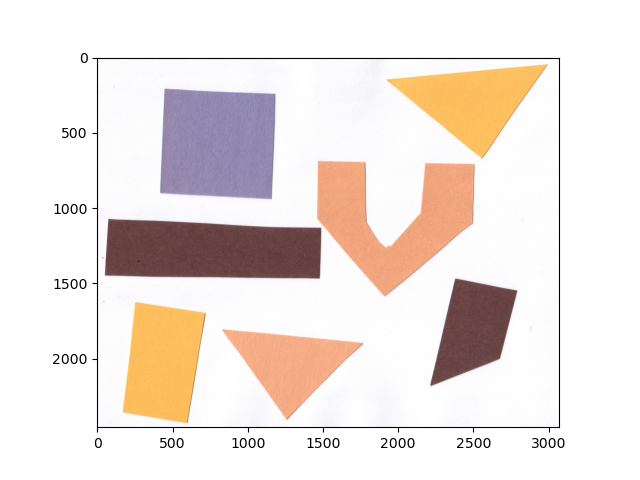

In [3]:
# load the image
img = iio.imread(uri="data/shapes-01.jpg")
fig, ax = plt.subplots()
plt.imshow(img)

Now suppose we want to select only the shapes from the image. In other words, we want to leave the pixels belonging to the shapes “on,” while turning the rest of the pixels “off,” by setting their colour channel values to zeros. The skimage library has several different methods of thresholding. We will start with the simplest version, which involves an important step of human input. Specifically, in this simple, fixed-level thresholding, we have to provide a threshold value t.

The process works like this. First, we will load the original image, convert it to grayscale, and de-noise it as in the Blurring Images episode.

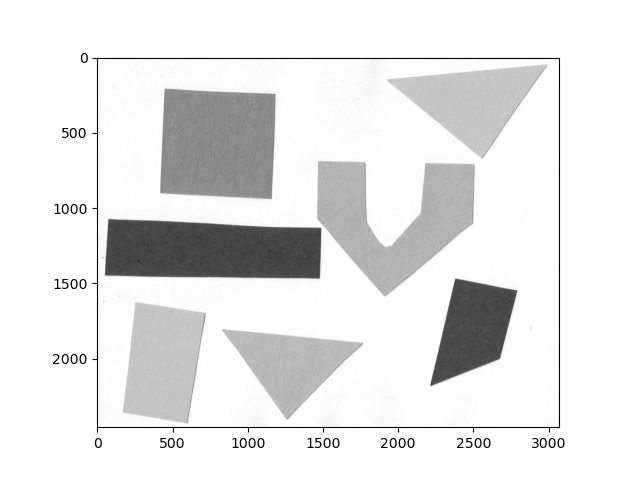

In [4]:
# convert the image to grayscale
gray_img = skimage.color.rgb2gray(img)

# blur the image to denoise
blurred_img = skimage.filters.gaussian(gray_img, sigma=1.0)

fig, ax = plt.subplots()
plt.imshow(blurred_img, cmap="gray")

Next, we would like to apply the threshold t such that pixels with grayscale values on one side of t will be turned “on”, while pixels with grayscale values on the other side will be turned “off”. How might we do that? Remember that grayscale images contain pixel values in the range from 0 to 1, so we are looking for a threshold t in the closed range [0.0, 1.0]. We see in the image that the geometric shapes are “darker” than the white background but there is also some light gray noise on the background. One way to determine a “good” value for t is to look at the grayscale histogram of the image and try to identify what grayscale ranges correspond to the shapes in the image or the background.

The histogram for the shapes image shown above can be produced as in the Creating Histograms episode.

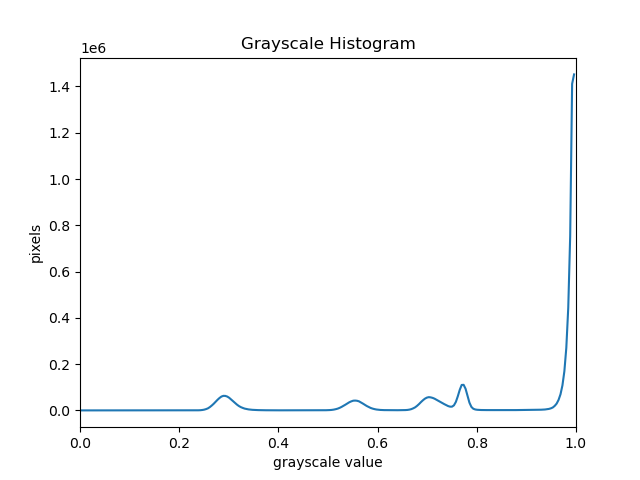

In [5]:
plot_hist(blurred_img, 256, 0.0, 1.0)

**Note: go through the histogram and ask them what they think each peak represents - background, labels, roots**

Since the image has a white background, most of the pixels in the image are white. This corresponds nicely to what we see in the histogram: there is a peak near the value of 1.0. If we want to select the shapes and not the background, we want to turn off the white background pixels, while leaving the pixels for the shapes turned on. So, we should choose a value of `t` somewhere before the large peak and turn pixels above that value “off”. Let us choose `t=0.8`.

To apply the threshold `t`, we can use the numpy comparison operators to create a mask. Here, we want to turn “on” all pixels which have values smaller than the threshold, so we use the less operator `<` to compare the `blurred_image` to the threshold `t`. The operator returns a mask, that we capture in the variable `binary_mask`. It has only one channel, and each of its values is either 0 or 1. The binary mask created by the thresholding operation can be shown with `plt.imshow`, where the `False` entries are shown as black pixels (0-valued) and the `True` entries are shown as white pixels (1-valued).

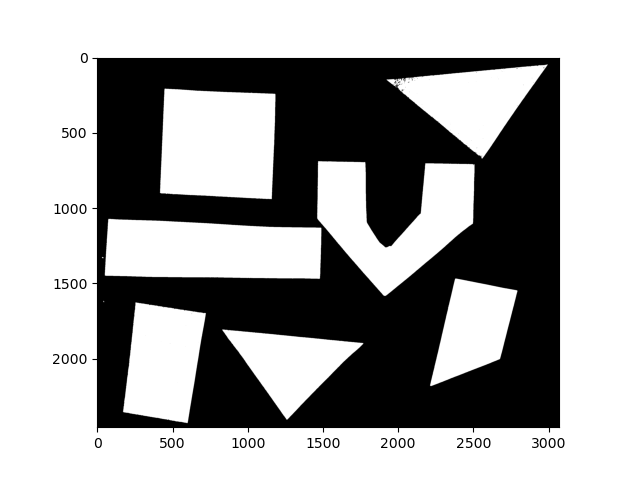

In [6]:
# create a mask based on the threshold
t = 0.8
binary_mask = blurred_img < t

fig, ax = plt.subplots()
plt.imshow(binary_mask, cmap="gray")

You can see that the areas where the shapes were in the original area are now white, while the rest of the mask image is black.

### What makes a good threshold?

As is often the case, the answer to this question is “it depends”. In the example above, we could have just switched off all the white background pixels by choosing t=1.0, but this would leave us with some background noise in the mask image. On the other hand, if we choose too low a value for the threshold, we could lose some of the shapes that are too bright. You can experiment with the threshold by re-running the above code lines with different values for t. In practice, it is a matter of domain knowledge and experience to interpret the peaks in the histogram so to determine an appropriate threshold. The process often involves trial and error, which is a drawback of the simple thresholding method. Below we will introduce automatic thresholding, which uses a quantitative, mathematical definition for a good threshold that allows us to determine the value of t automatically. It is worth noting that the principle for simple and automatic thresholding can also be used for images with pixel ranges other than [0.0, 1.0]. For example, we could perform thresholding on pixel intensity values in the range [0, 255] as we have already seen in the Image Representation in skimage episode.

We can now apply the binary_mask to the original coloured image as we have learned in the Drawing and Bitwise Operations episode. What we are left with is only the coloured shapes from the original.

In [7]:
# use the binary_mask to select the "interesting" part of the image
selection = img.copy()
selection[~binary_mask] = 0

fig, ax = plt.subplots()
plt.imshow(selection)

### Exercise: more practice with simple thresholding (15 min)

Now, it is your turn to practice. Suppose we want to use simple thresholding to select only the coloured shapes (in this particular case we consider grayish to be a colour, too) from the image `data/shapes-02.jpg`.

First, plot the grayscale histogram as in the Creating Histogram episode and examine the distribution of grayscale values in the image. What do you think would be a good value for the threshold t?

_Solution_

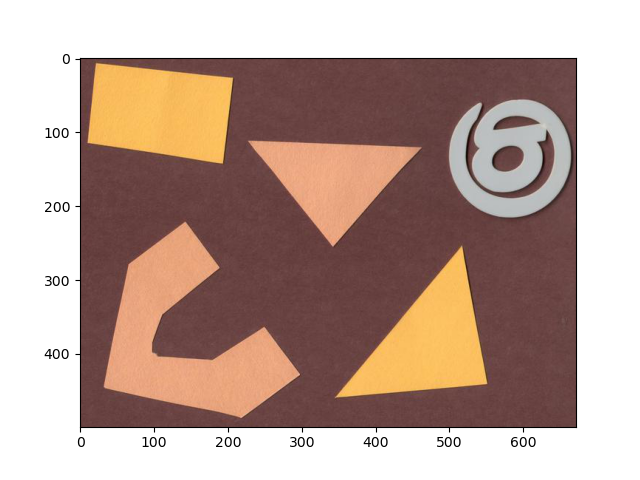

In [8]:
# my "extra" cell to load the image
img = iio.imread(uri="data/shapes-02.jpg")
fig, ax = plt.subplots()
plt.imshow(img)

The histogram for the `data/shapes-02.jpg` image can be shown with

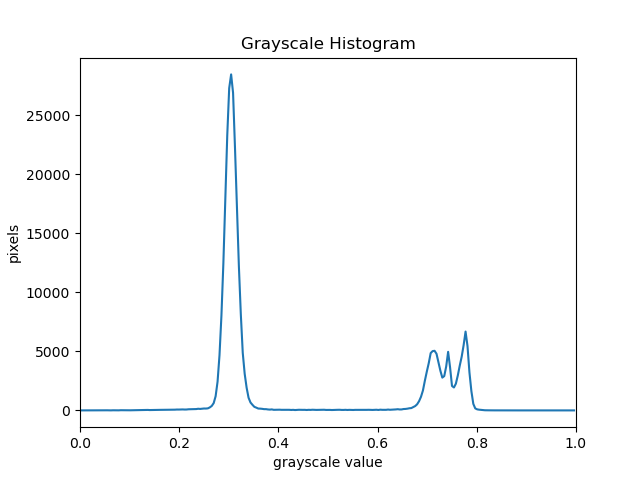

In [9]:
# gray_image = iio.imread(uri="data/shapes-02.jpg", mode='L')
gray_img = iio.imread(uri="data/shapes-02.jpg", mode='L') / 255
plot_hist(gray_img, 256, 0.0, 1.0)

We can see a large spike around 0.3, and a smaller spike around 0.7. The spike near 0.3 represents the darker background, so it seems like a value close to `t=0.5` would be a good choice.

Next, create a mask to turn the pixels above the threshold `t` on and pixels below the threshold `t` off. Note that unlike the image with a white background we used above, here the peak for the background colour is at a lower gray level than the shapes. Therefore, change the comparison operator less `<` to greater `>` to create the appropriate mask. Then apply the mask to the image and view the thresholded image. If everything works as it should, your output should show only the coloured shapes on a black background.

_Solution_

Here are the commands to create and view the binary mask

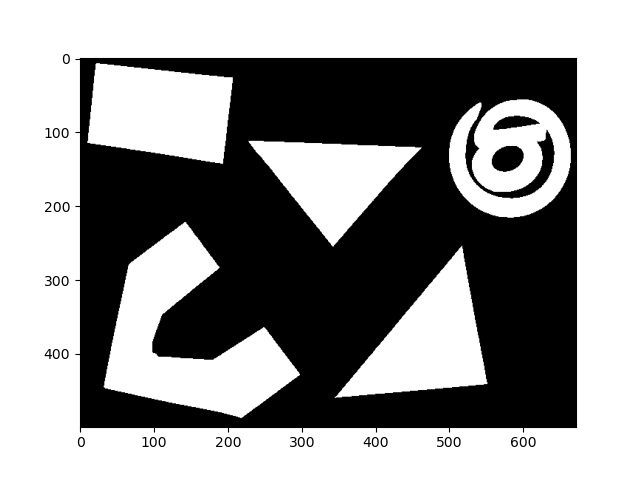

In [10]:
t = 0.5
binary_mask = gray_img > t

fig, ax = plt.subplots()
plt.imshow(binary_mask, cmap="gray")

And here are the commands to apply the mask and view the thresholded image



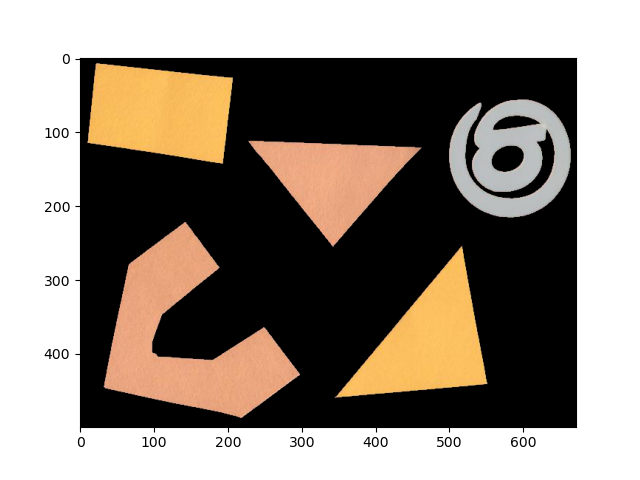

In [11]:
img = iio.imread(uri="data/shapes-02.jpg")
selection = img.copy()
selection[~binary_mask] = 0

fig, ax = plt.subplots()
plt.imshow(selection)

### Automatic thresholding

The downside of the simple thresholding technique is that we have to make an educated guess about the threshold t by inspecting the histogram. There are also automatic thresholding methods that can determine the threshold automatically for us. One such method is Otsu’s method. It is particularly useful for situations where the grayscale histogram of an image has two peaks that correspond to background and objects of interest.

Consider the image data/maize-root-cluster.jpg of a maize root system which we have seen before in the Image Representation in skimage episode.

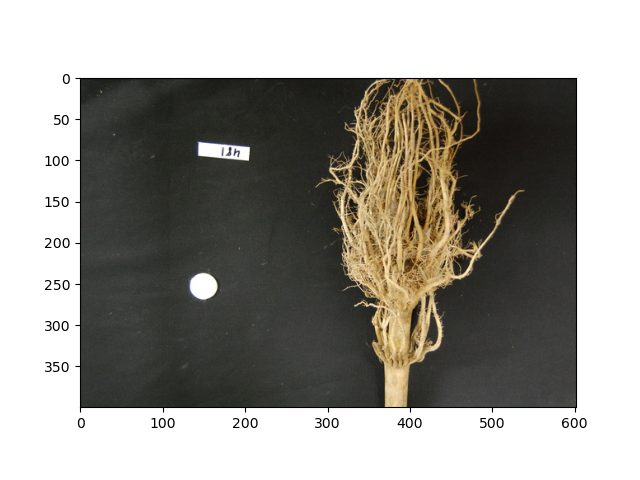

In [12]:
img = iio.imread(uri="data/maize-root-cluster.jpg")

fig, ax = plt.subplots()
plt.imshow(img)

We use Gaussian blur with a sigma of 1.0 to denoise the root image. Let us look at the grayscale histogram of the denoised image.

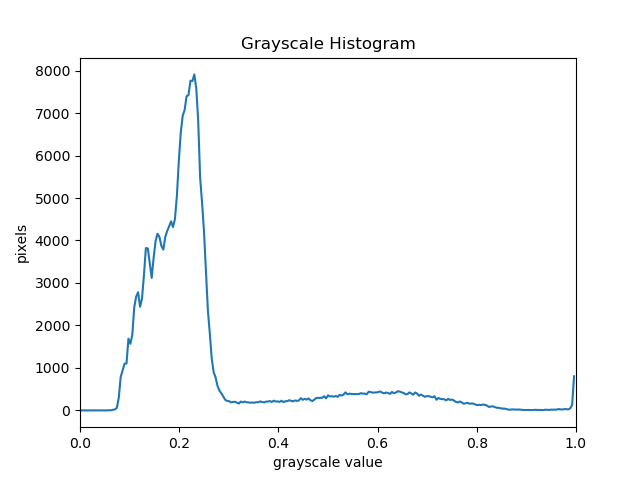

In [13]:
# convert the image to grayscale
gray_img = skimage.color.rgb2gray(img)

# blur the image to denoise
blurred_img = skimage.filters.gaussian(gray_img, sigma=1.0)

# show the histogram of the blurred image
plot_hist(blurred_img, 256, 0, 1)

The histogram has a significant peak around 0.2, and a second, smaller peak very near 1.0. Thus, this image is a good candidate for thresholding with Otsu’s method. The mathematical details of how this works are complicated (see the skimage documentation if you are interested), but the outcome is that Otsu’s method finds a threshold value between the two peaks of a grayscale histogram.

The skimage.filters.threshold_otsu() function can be used to determine the threshold automatically via Otsu’s method. Then numpy comparison operators can be used to apply it as before. Here are the Python commands to determine the threshold t with Otsu’s method.

In [14]:
# perform automatic thresholding
t = skimage.filters.threshold_otsu(blurred_img)
print("Found automatic threshold t = {}.".format(t))

Found automatic threshold t = 0.4113342270063075.


For this root image and a Gaussian blur with the chosen sigma of 1.0, the computed threshold value is 0.42. No we can create a binary mask with the comparison operator `>`. As we have seen before, pixels above the threshold value will be turned on, those below the threshold will be turned off.

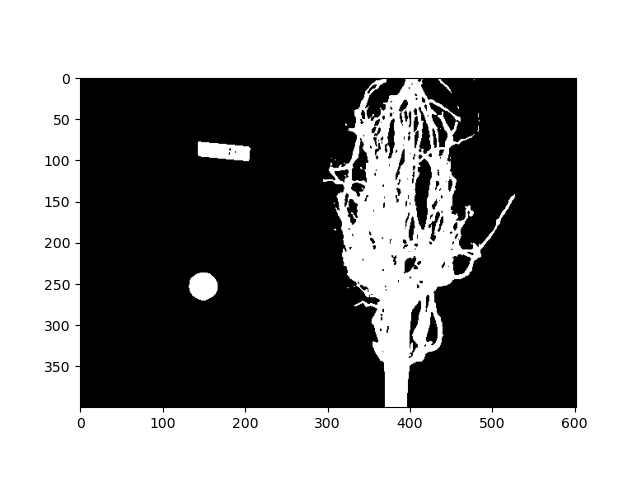

In [15]:
# create a binary mask with the threshold found by Otsu's method
binary_mask = blurred_img > t

fig, ax = plt.subplots()
plt.imshow(binary_mask, cmap="gray")

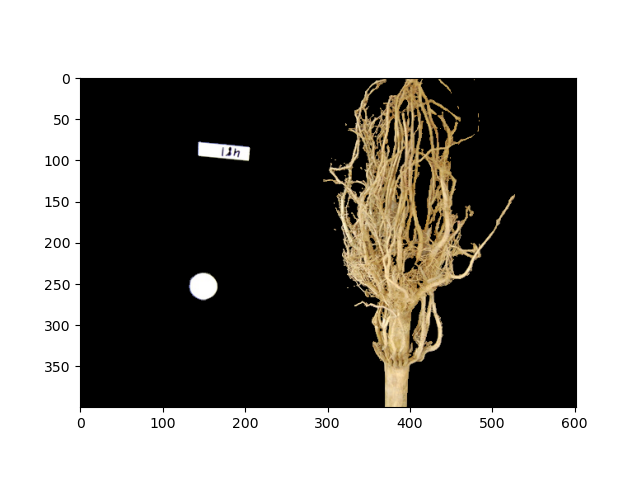

In [16]:
# apply the binary mask to select the foreground
selection = img.copy()
selection[~binary_mask] = 0

fig, ax = plt.subplots()
plt.imshow(selection)

### Application: measuring root mass

Let us now turn to an application where we can apply thresholding and other techniques we have learned to this point. Consider these four maize root system images, which you can find in the files `data/trial-016.jpg`, `data/trial-020.jpg`, `data/trial-216.jpg`, and `data/trial-293.jpg`.

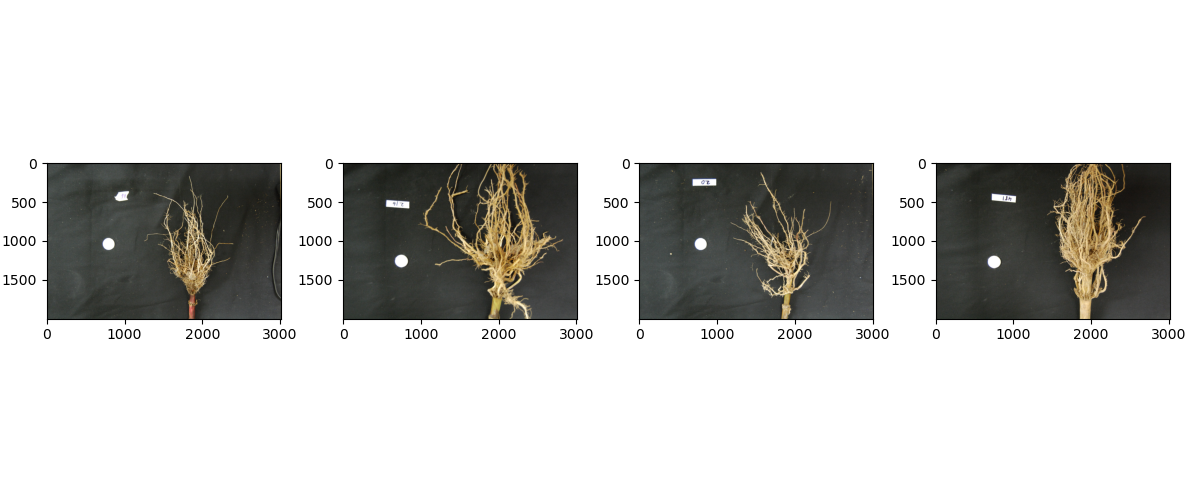

In [17]:
# my "extra" cell to show the images
all_files = glob.glob("data/trial-*.jpg")
fig, ax = plt.subplots(1,4, figsize=(12,5))
fig.tight_layout()
for idx, filename in enumerate(all_files):
    # read the original image, converting to grayscale on the fly
    img = iio.imread(uri=all_files[idx])
    ax[idx].imshow(img)

Suppose we are interested in the amount of plant material in each image, and in particular how that amount changes from image to image. Perhaps the images represent the growth of the plant over time, or perhaps the images show four different maize varieties at the same phase of their growth. The question we would like to answer is, “how much root mass is in each image?”

We will first construct a Python program to measure this value for a single image. Our strategy will be this:

1. Read the image, converting it to grayscale as it is read. For this application we do not need the colour image.
2. Blur the image.
3. Use Otsu’s method of thresholding to create a binary image, where the pixels that were part of the maize plant are white, and everything else is black.
4. Save the binary image so it can be examined later.
5. Count the white pixels in the binary image, and divide by the number of pixels in the image. This ratio will be a measure of the root mass of the plant in the image.
6. Output the name of the image processed and the root mass ratio.

Our intent is to perform these steps and produce the numeric result - a measure of the root mass in the image - without human intervention. Implementing the steps within a Python function will enable us to call this function for different images.

Here is a Python function that implements this root-mass-measuring strategy. Since the function is intended to produce numeric output without human interaction, it does not display any of the images. Almost all of the commands should be familiar, and in fact, it may seem simpler than the code we have worked on thus far, because we are not displaying any of the images.

In [18]:
def measure_root_mass(filename, sigma=1.0):

    # read the original image, converting to grayscale on the fly
    img = iio.imread(uri=filename, mode="L")

    # blur before thresholding
    blurred_img = skimage.filters.gaussian(img, sigma=sigma)

    # perform automatic thresholding to produce a binary image
    t = skimage.filters.threshold_otsu(blurred_img)
    binary_mask = blurred_img > t

    # determine root mass ratio
    rootPixels = np.count_nonzero(binary_mask)
    w = binary_mask.shape[1]
    h = binary_mask.shape[0]
    density = rootPixels / (w * h)

    return density

The function begins with reading the original image from the file `filename`. We use `iio.imread()` with the optional argument `mode="L"` to automatically convert it to grayscale. Next, the grayscale image is blurred with a Gaussian filter with the value of `sigma` that is passed to the function. Then we determine the threshold `t` with Otsu’s method and create a binary mask just as we did in the previous section. Up to this point, everything should be familiar.

The final part of the function determines the root mass ratio in the image. Recall that in the `binary_mask`, every pixel has either a value of zero (black/background) or one (white/foreground). We want to count the number of white pixels, which can be accomplished with a call to the numpy function `np.count_nonzero`. Then we determine the width and height of the image by using the elements of `binary_mask.shape` (that is, the dimensions of the numpy array that stores the image). Finally, the density ratio is calculated by dividing the number of white pixels by the total number of pixels `w*h` in the image. The function returns then root density of the image.

We can call this function with any filename and provide a sigma value for the blurring. If no sigma value is provided, the default value 1.0 will be used. For example, for the file `data/trial-016.jpg` and a sigma value of 1.5, we would call the function like this:

In [19]:
measure_root_mass(filename="data/trial-016.jpg", sigma=1.5)

0.04907413563829787

Now we can use the function to process the series of four images shown above. In a real-world scientific situation, there might be dozens, hundreds, or even thousands of images to process. To save us the tedium of calling the function for each image by hand, we can write a loop that processes all files automatically. The following code block assumes that the files are located in the same directory and the filenames all start with the trial- prefix and end with the .jpg suffix.


In [20]:
all_files = glob.glob("data/trial-*.jpg")
for filename in all_files:
    density = measure_root_mass(filename=filename, sigma=1.5)
    # output in format suitable for .csv
    print(filename, density, sep=",")

data/trial-016.jpg,0.04907413563829787
data/trial-216.jpg,0.1420516954787234
data/trial-020.jpg,0.06381349734042553
data/trial-293.jpg,0.13665458776595746


### Exercise: ignoring more of the images – brainstorming (10 min)

Let us take a closer look at the binary masks produced by the `measure_root_mass` function.

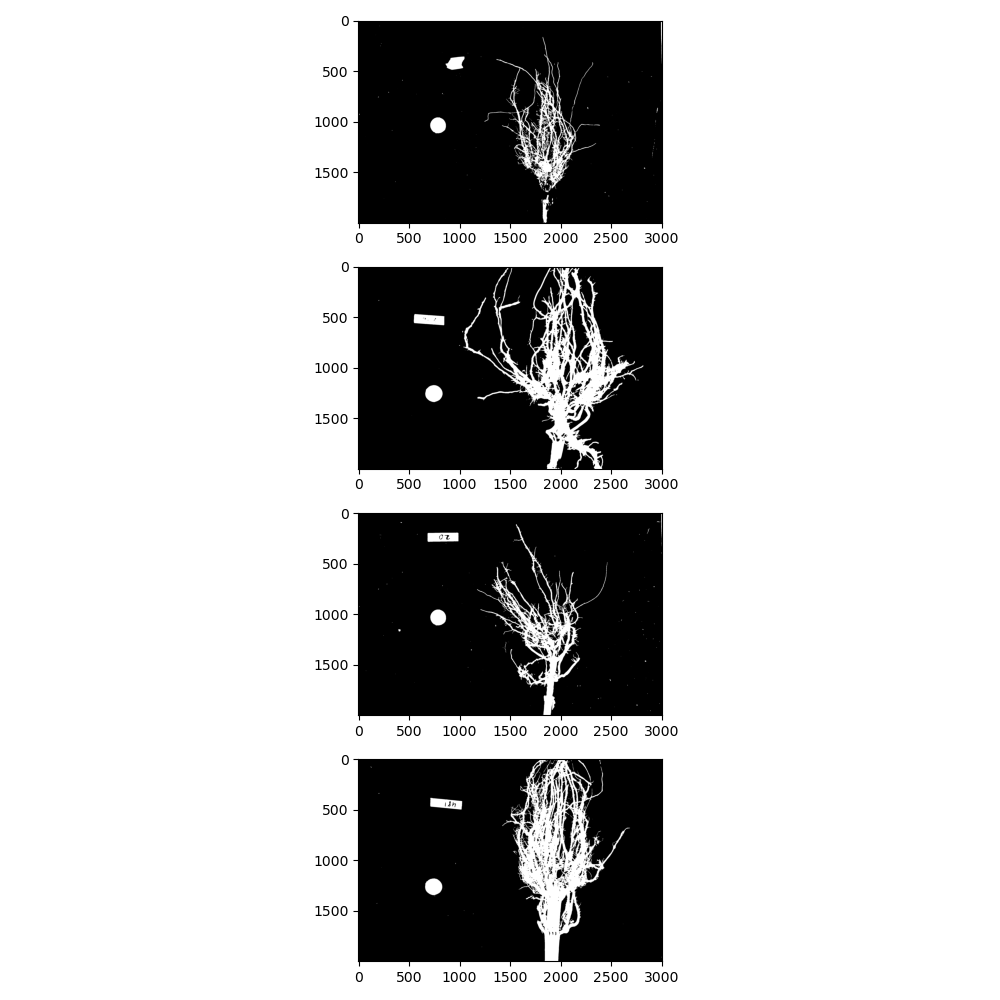

In [21]:
# my "extra" cell to take a closer look
all_files = glob.glob("data/trial-*.jpg")
fig, ax = plt.subplots(4,1, figsize=(10,10))
fig.tight_layout()
for idx, filename in enumerate(all_files):
    # read the original image, converting to grayscale on the fly
    img = iio.imread(uri=all_files[idx], mode="L")
    # blur before thresholding
    blurred_img = skimage.filters.gaussian(img, sigma=1.5)
    t = skimage.filters.threshold_otsu(blurred_img)
    binary_mask = blurred_img > t
    ax[idx].imshow(binary_mask, cmap="gray")

You may have noticed in the section on automatic thresholding that the thresholded image does include regions of the image aside of the plant root: the numbered labels and the white circles in each image are preserved during the thresholding, because their grayscale values are above the threshold. Therefore, our calculated root mass ratios include the white pixels of the label and white circle that are not part of the plant root. Those extra pixels affect how accurate the root mass calculation is!

How might we remove the labels and circles before calculating the ratio, so that our results are more accurate? Think about some options given what we have learned so far.

_Solution_

One approach we might take is to try to completely mask out a region from each image, particularly, the area containing the white circle and the numbered label. If we had coordinates for a rectangular area on the image that contained the circle and the label, we could mask the area out easily by using techniques we learned in the Drawing and Bitwise Operations episode.

However, a closer inspection of the binary images raises some issues with that approach. Since the roots are not always constrained to a certain area in the image, and since the circles and labels are in different locations each time, we would have difficulties coming up with a single rectangle that would work for every image. We could create a different masking rectangle for each image, but that is not a practicable approach if we have hundreds or thousands of images to process.

Another approach we could take is to apply two thresholding steps to the image. Look at the graylevel histogram of the file data/trial-016.jpg shown above again: Notice the peak near 1.0? Recall that a grayscale value of 1.0 corresponds to white pixels: the peak corresponds to the white label and circle. So, we could use simple binary thresholding to mask the white circle and label from the image, and then we could use Otsu’s method to select the pixels in the plant portion of the image.

Note that most of this extra work in processing the image could have been avoided during the experimental design stage, with some careful consideration of how the resulting images would be used. For example, all of the following measures could have made the images easier to process, by helping us predict and/or detect where the label is in the image and subsequently mask it from further processing:

- Using labels with a consistent size and shape
- Placing all the labels in the same position, relative to the sample
- Using a non-white label, with non-black writing


### Exercise: ignoring more of the images – implementation (30 min - optional, not included in timing)

Implement an enhanced version of the function measure_root_mass that applies simple binary thresholding to remove the white circle and label from the image before applying Otsu’s method.

**Note: make them think more about this double threshold exercise**

_Solution_

We can apply a simple binary thresholding with a threshold t=0.95 to remove the label and circle from the image. We use the binary mask to set the pixels in the blurred image to zero (black).

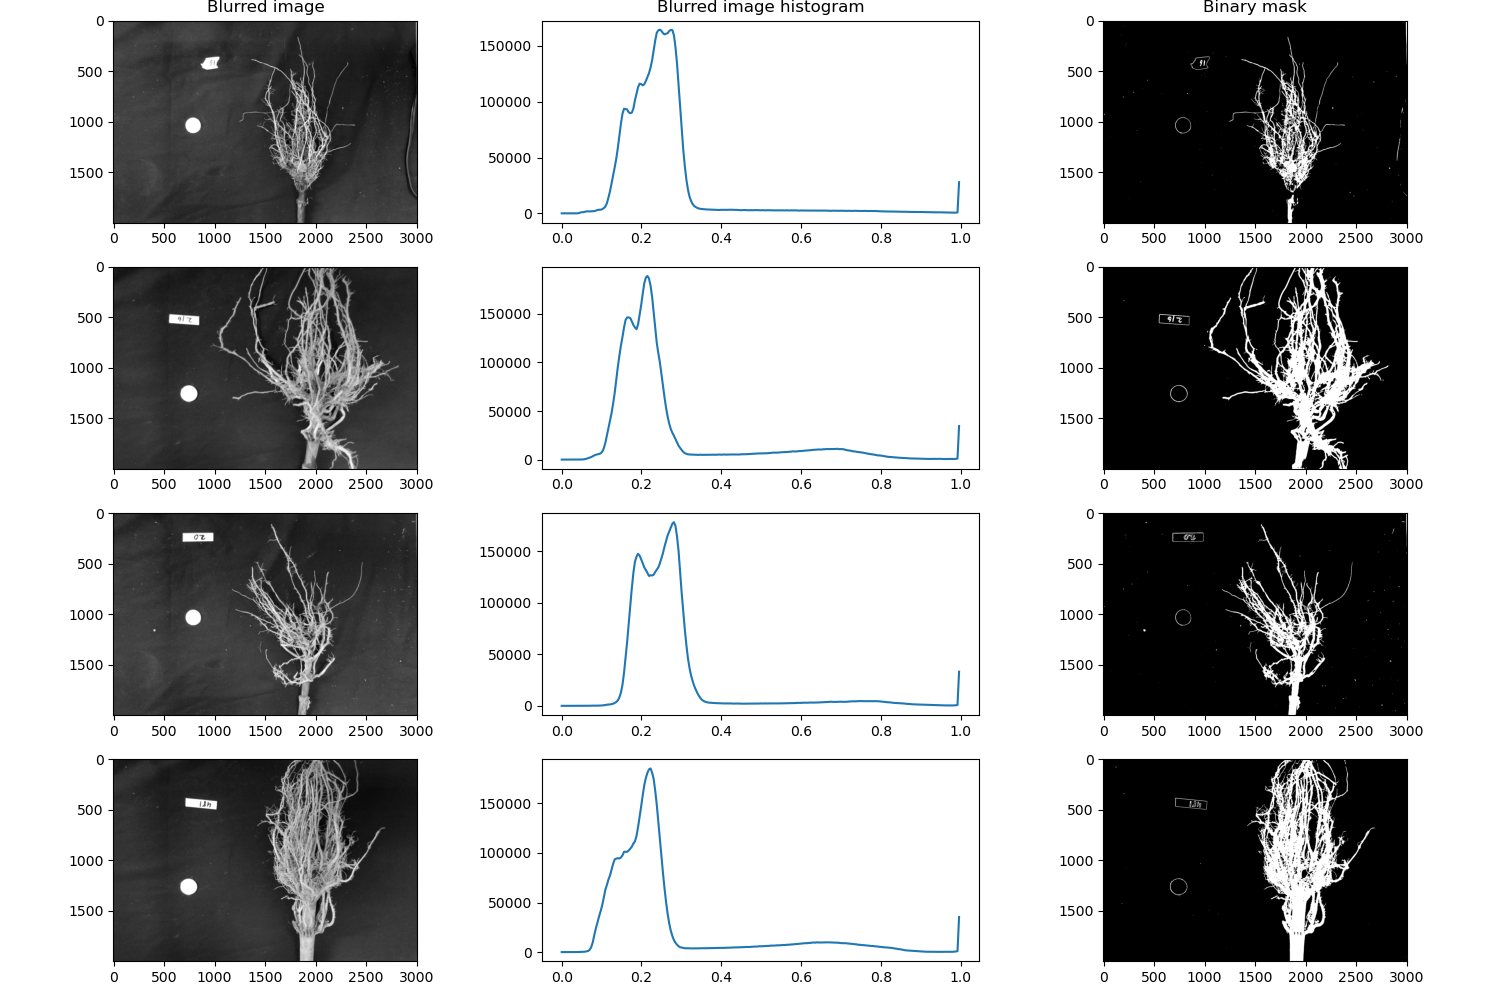

In [22]:
# my "extra" cell to show the process
all_files = glob.glob("data/trial-*.jpg")
fig, ax = plt.subplots(4,3, figsize=(15, 10))
fig.tight_layout()
for idx, filename in enumerate(all_files):
    # read the original image, converting to grayscale on the fly
    img = iio.imread(uri=all_files[idx], mode="L")
    # blur before thresholding
    blurred_img = skimage.filters.gaussian(img, sigma=1.5)
    histogram, bin_edges = np.histogram(blurred_img, bins=256, range=(0.0, 1.0))
    t1 = 0.95
    binary_mask1 = blurred_img < t1
    selection = blurred_img.copy()
    selection[~binary_mask1] = 0
    # perform automatic thresholding to produce a binary image
    t = skimage.filters.threshold_otsu(selection)
    binary_mask = selection > t
    ax[idx,0].imshow(blurred_img, cmap="gray")
    ax[idx,1].plot(bin_edges[0:-1], histogram)
    ax[idx,2].imshow(binary_mask, cmap="gray")

ax[0,0].title.set_text("Blurred image")
ax[0,1].title.set_text("Blurred image histogram")
ax[0,2].title.set_text("Binary mask")

In [23]:
def enhanced_root_mass(filename, sigma):

    # read the original image, converting to grayscale on the fly
    img = iio.imread(uri=filename, mode="L")

    # blur before thresholding
    blurred_img = skimage.filters.gaussian(img, sigma=sigma)

    # perform binary thresholding to mask the white label and circle
    binary_mask = blurred_img < 0.95
    # use the mask to remove the circle and label from the blurred image
    blurred_img[~binary_mask] = 0

    # perform automatic thresholding to produce a binary image
    t = skimage.filters.threshold_otsu(blurred_img)
    binary_mask = blurred_img > t

    # determine root mass ratio
    rootPixels = np.count_nonzero(binary_mask)
    w = binary_mask.shape[1]
    h = binary_mask.shape[0]
    density = rootPixels / (w * h)

    return density

all_files = glob.glob("data/trial-*.jpg")
for filename in all_files:
    density = enhanced_root_mass(filename=filename, sigma=1.5)
    # output in format suitable for .csv
    print(filename, density, sep=",")

data/trial-016.jpg,0.04632878989361702
data/trial-216.jpg,0.13761419547872342
data/trial-020.jpg,0.05924468085106383
data/trial-293.jpg,0.1323479055851064


The output of the improved program does illustrate that the white circles and labels were skewing our root mass ratios.

The binary images produced by the additional thresholding. Note that we have not completely removed the offending white pixels. Outlines still remain. However, we have reduced the number of extraneous pixels, which should make the output more accurate.

### Exercise: thresholding a bacteria colony image (15 min)

In the images directory `data/`, you will find an image named `colonies-01.tif`.

This is one of the images you will be working with in the morphometric challenge at the end of the workshop.

1. Plot and inspect the grayscale histogram of the image to determine a good threshold value for the image.
2. Create a binary mask that leaves the pixels in the bacteria colonies “on” while turning the rest of the pixels in the image “off”.

_Solution_

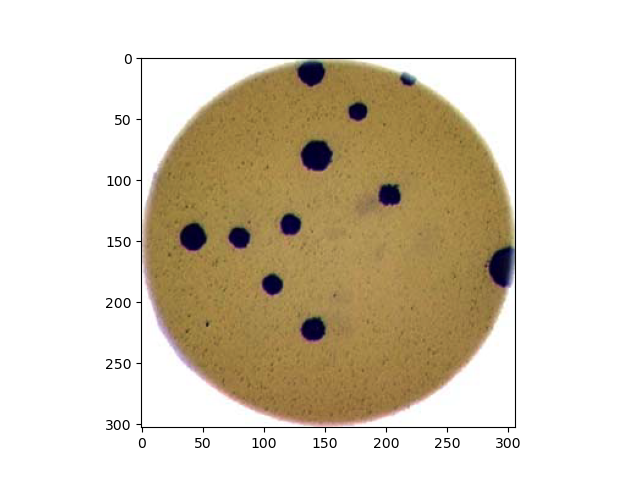

In [24]:
# my "extra" cell to load the image
img = iio.imread(uri="data/colonies-01.tif")
fig, ax = plt.subplots()
plt.imshow(img)

Here is the code to create the grayscale histogram:

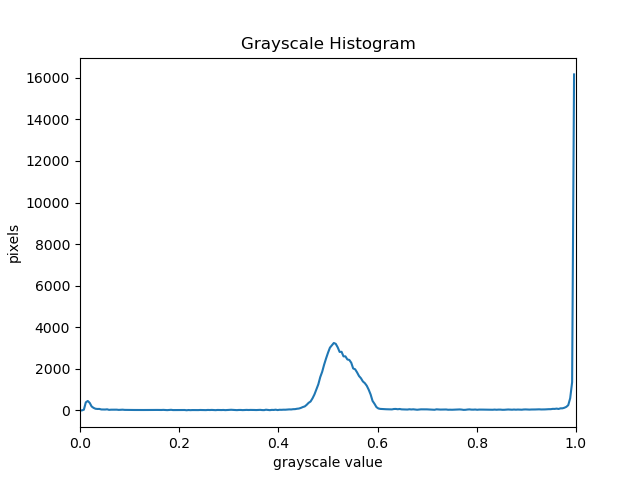

In [25]:
img = iio.imread(uri="data/colonies-01.tif")
gray_img = skimage.color.rgb2gray(img)
blurred_img = skimage.filters.gaussian(gray_img, sigma=1.0)
plot_hist(blurred_img, 256, 0, 1.0)

The peak near one corresponds to the white image background, and the broader peak around 0.5 corresponds to the yellow/brown culture medium in the dish. The small peak near zero is what we are after: the dark bacteria colonies. A reasonable choice thus might be to leave pixels below `t=0.2` on.

Here is the code to create and show the binarized image using the `<` operator with a threshold `t=0.2`:

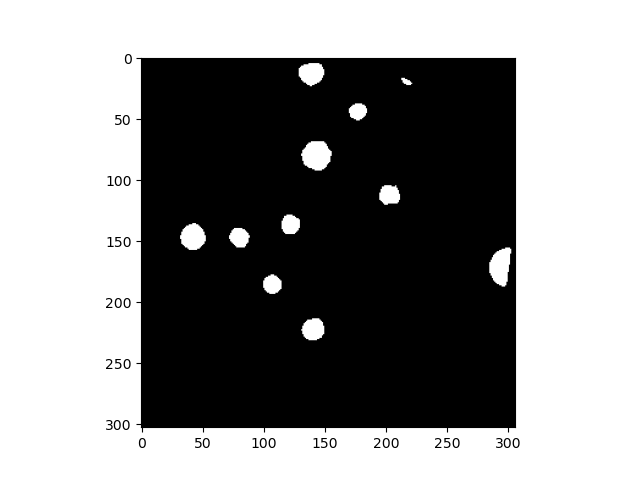

In [26]:
t = 0.2
binary_mask = blurred_img < t

fig, ax = plt.subplots()
plt.imshow(binary_mask, cmap="gray")

When you experiment with the threshold a bit, you can see that in particular the size of the bacteria colony near the edge of the dish in the top right is affected by the choice of the threshold.

### Key Points

- Thresholding produces a binary image, where all pixels with intensities above (or below) a threshold value are turned on, while all other pixels are turned off.

- The binary images produced by thresholding are held in two-dimensional NumPy arrays, since they have only one colour value channel. They are boolean, hence they contain the values 0 (off) and 1 (on).

- Thresholding can be used to create masks that select only the interesting parts of an image, or as the first step before edge detection or finding contours.